## CONVOLUTIONAL NEURAL NETWORK 2 (MNIST)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CURRENT TF VERSION IS [1.10.0]
PACKAGES LOADED


## LOAD MNIST

In [2]:
mnist = input_data.read_data_sets('../data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
MNIST ready


## DEFINE MODEL

In [3]:
# NETWORK TOPOLOGIES
n_input    = 784
n_channel  = 64 
n_classes  = 10  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'c1': tf.Variable(tf.random_normal([7, 7, 1, n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([5, 5, n_channel, n_channel], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([14*14*64, n_classes], stddev=stddev))
}
biases = {
    'c1': tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'c2': tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [4]:
# MODEL
def CNN(_x, _w, _b):
    # RESHAPE
    _x_r = tf.reshape(_x, shape=[-1, 28, 28, 1])
    # TODO1: CONVOLUTION
    _conv1 = tf.nn.conv2d(_x_r,_w['c1'],strides=[1,1,1,1],padding='SAME')
    # ADD BIAS
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # RELU
    _conv3 = tf.nn.relu(_conv2)
    # TODO2: MAX-POOL
#     _pool  = tf.nn.max_pool(_conv3, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
    _conv4 = tf.nn.conv2d(_conv3,_w['c2'],strides=[1,2,2,1],padding='SAME')
    _conv5 = tf.nn.bias_add(_conv4, _b['c2'])
    _conv6 = tf.nn.relu(_conv5)    
    # VECTORIZE
    _dense = tf.reshape(_conv6, [-1, _w['d1'].get_shape().as_list()[0]])
    # DENSE
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r': _x_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
        , 'conv4': _conv4, 'conv5': _conv5, 'conv6': _conv6
        , 'dense': _dense, 'logit': _logit
    }
    return _out

# PREDICTION
cnnout = CNN(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(cnnout['logit'], 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

FUNCTIONS READY


## SAVER

In [5]:
dirpath = "data/nets"
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
savedir = "data/nets/cnn_mnist_simple/"
saver = tf.train.Saver(max_to_keep=3)
save_step = 5
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


## RUN

In [6]:
# PARAMETERS
training_epochs = 5
batch_size      = 32
display_step    = 1
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        # TODO3: Fill in the for loop where we run the graph, compute the cost, and optimize.
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)        
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: mnist.test.images, y: mnist.test.labels}
        test_acc = sess.run(accr, feed_dict=feeds)
        print ("TEST ACCURACY: %.3f" % (test_acc))
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir+"net-"+str(epoch+1)+".ckpt"
        saver.save(sess, savename)
        print ("[%s] SAVED." % (savename))
print ("OPTIMIZATION FINISHED")

Epoch: 001/005 cost: 0.154399072
TRAIN ACCURACY: 0.969
TEST ACCURACY: 0.982
Epoch: 002/005 cost: 0.038982831
TRAIN ACCURACY: 0.969
TEST ACCURACY: 0.985
Epoch: 003/005 cost: 0.022482400
TRAIN ACCURACY: 1.000
TEST ACCURACY: 0.985
Epoch: 004/005 cost: 0.014416509
TRAIN ACCURACY: 0.938
TEST ACCURACY: 0.985
Epoch: 005/005 cost: 0.010175271
TRAIN ACCURACY: 1.000
TEST ACCURACY: 0.984
[data/nets/cnn_mnist_simple/net-5.ckpt] SAVED.
OPTIMIZATION FINISHED


## RESTORE

In [7]:
do_restore = 0
if do_restore == 1:
    sess = tf.Session()
    epoch = 5
    savename = savedir+"net-"+str(epoch)+".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print ("DO NOTHING")

DO NOTHING


## SEE HOW IT WORKS

In [8]:
# FEEDFORWARD THE FIRST TRAIN IMAGE
input_r = sess.run(cnnout['x_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(cnnout['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(cnnout['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(cnnout['conv3'], feed_dict={x: trainimg[0:1, :]})
conv4   = sess.run(cnnout['conv4'], feed_dict={x: trainimg[0:1, :]})
conv5   = sess.run(cnnout['conv5'], feed_dict={x: trainimg[0:1, :]})
conv6   = sess.run(cnnout['conv6'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(cnnout['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(cnnout['logit'], feed_dict={x: trainimg[0:1, :]})

## INPUT

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


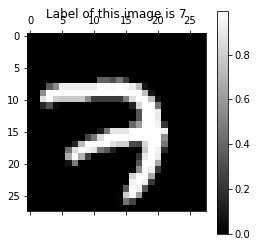

In [9]:
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# PLOT
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

## CONV

SIZE OF 'CONV1' IS (1, 28, 28, 64)


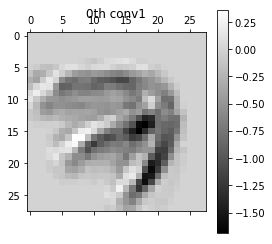

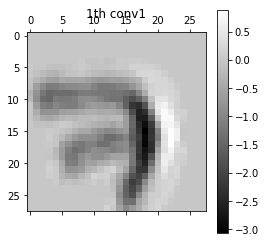

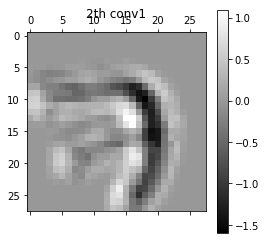

In [10]:
print ("SIZE OF 'CONV1' IS %s" % (conv1.shape,))
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show()

## CONV + BIAS

SIZE OF 'CONV2' IS (1, 28, 28, 64)


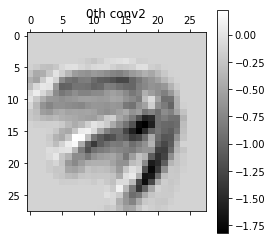

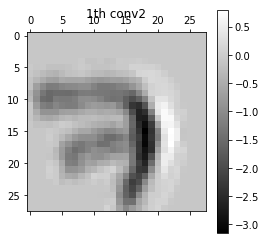

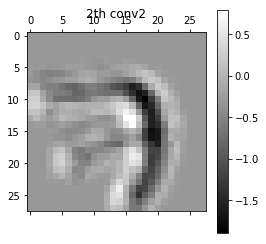

In [11]:
print ("SIZE OF 'CONV2' IS %s" % (conv2.shape,))
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show()

## CONV + BIAS + RELU

SIZE OF 'CONV3' IS (1, 28, 28, 64)


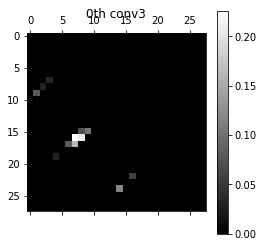

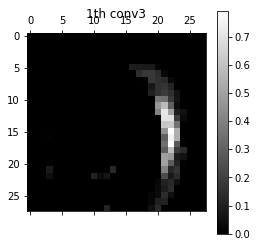

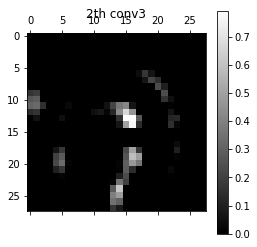

In [12]:
print ("SIZE OF 'CONV3' IS %s" % (conv3.shape,))
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show()

## CONV2

SIZE OF 'CONV4' IS (1, 14, 14, 64)


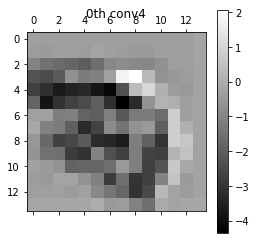

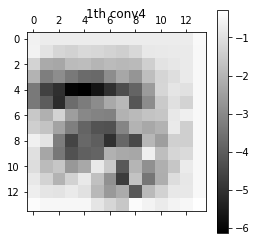

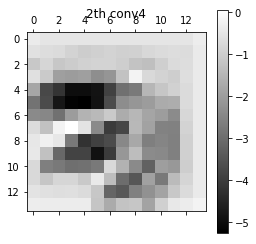

In [14]:
print ("SIZE OF 'CONV4' IS %s" % (conv4.shape,))
for i in range(3):
    plt.matshow(conv4[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv4")
    plt.colorbar()
    plt.show()

## CONV2 + BIAS

SIZE OF 'CONV5' IS (1, 14, 14, 64)


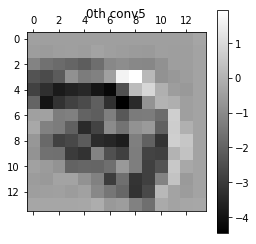

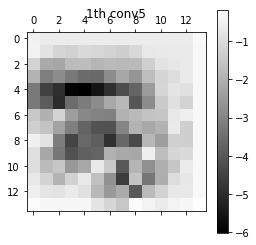

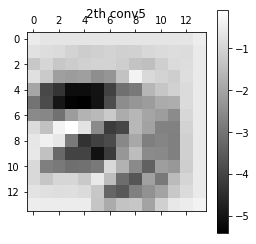

In [15]:
print ("SIZE OF 'CONV5' IS %s" % (conv5.shape,))
for i in range(3):
    plt.matshow(conv5[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv5")
    plt.colorbar()
    plt.show()

## CONV2 + BIAS + RELU

SIZE OF 'CONV6' IS (1, 14, 14, 64)


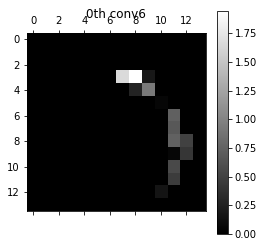

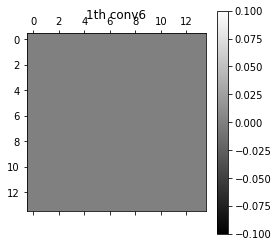

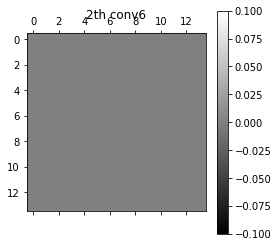

In [16]:
print ("SIZE OF 'CONV6' IS %s" % (conv6.shape,))
for i in range(3):
    plt.matshow(conv6[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv6")
    plt.colorbar()
    plt.show()

## DENSE

SIZE OF 'DENSE' IS (1, 12544)
SIZE OF 'OUT' IS (1, 10)


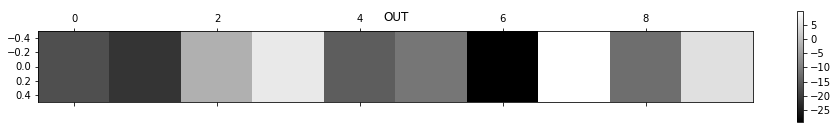

PREDICTED LABEL IS [7]


In [17]:
print ("SIZE OF 'DENSE' IS %s" % (dense.shape,))
print ("SIZE OF 'OUT' IS %s" % (out.shape,))
plt.matshow(out, cmap=plt.get_cmap('gray'))
plt.title("OUT")
plt.colorbar()
plt.show()

print ("PREDICTED LABEL IS [%d]" % np.argmax(out))

## CONV FILTER

SIZE OF 'WC1' IS (7, 7, 1, 64)


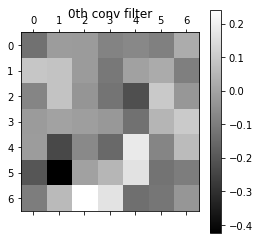

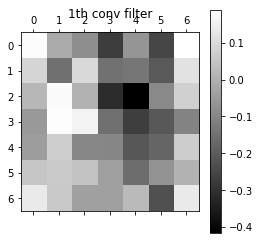

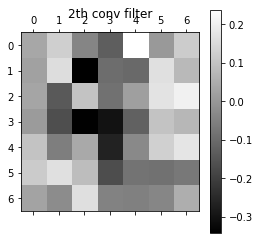

In [18]:
wc1 = sess.run(weights['c1'])
print ("SIZE OF 'WC1' IS %s" % (wc1.shape,))
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()

## CONV2 FILTER

SIZE OF 'WC2' IS (5, 5, 64, 64)


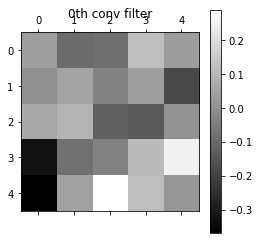

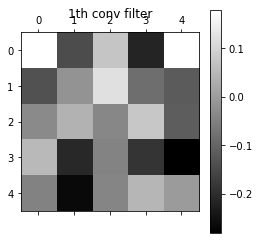

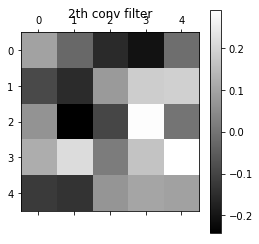

In [19]:
wc2 = sess.run(weights['c2'])
print ("SIZE OF 'WC2' IS %s" % (wc2.shape,))
for i in range(3):
    plt.matshow(wc2[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()